# Libraries

In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from sklearn.neighbors import KDTree
import joblib
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

Using TensorFlow backend.


In [2]:
import IPython.display as ipd

In [3]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [4]:
import sys
sys.path.insert(1, '../Images')
import utils_2d

In [5]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Images/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

## Load models

We only load the model with the best retrieval scores from the last notebook:

In [6]:
models_dir = "../Images/models"
model_number = "31_maxpool"
simple_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)

In [7]:
mask = utils_2d.create_mask()
new_width = 100

def simple_preprocessing(img):
    img = img[:,:,::-1].astype('uint8')
    gray = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
    gray = simple_prep_fun(gray)
    return gray

## Load Features Functions

In [8]:
def compute_features(img, model, preprocessing):
    img = kimage.img_to_array(img)
    img = preprocessing(img)
    if len(img.shape) == 3:
        x = img[np.newaxis, :,:,:]
    else:
        x = img[np.newaxis,:,:,np.newaxis] 
    f = model.predict(x)
    return f.flatten()

In [9]:
# Data loader
def load_data(base_path, model, preprocessing, pics_per_person=3, color_mode = "rgb",
              target_size=(224,224), file_formats=["png", "jpg"], folders = None, np_seed = 0):

    paths = []
    features = []
    if folders is None:
        folders = os.listdir(base_path)
    for folder in folders:
        #print(folder)
        path = base_path + "/" + folder
        if os.path.isdir(path):
            filenames = os.listdir(path)
            np.random.seed(np_seed)
            random_filenames = np.random.choice(filenames, pics_per_person, replace=False)
            for f in sorted(random_filenames):
                if (f[-3:] in file_formats):
                    # Memorizza percorso file
                    cur_path = path+"/" + f
                    paths.append(cur_path)
                    # Carica file ed estraine le features
                    image = kimage.load_img(cur_path, target_size=(224, 224), color_mode = color_mode)
                    cur_features = compute_features(image, model, preprocessing)
                    features.append(cur_features)

    features = np.array(features)
    return features, np.array(paths)

# Retrieval - Celebrities pictures

In [10]:
folders = labels
folders

array(['alessandro', 'alinda', 'cami', 'gian', 'khaled', 'luca', 'mamma',
       'papi'], dtype='<U10')

In [11]:
path = "celebrities_sample/"

In [12]:
classes = os.listdir(path)
classes

['michelle obama',
 'martina hingis',
 'liv tyler',
 'bill gates',
 'aishwarya rai',
 'adrien brody',
 'adam brody',
 'steve jobs',
 'aaron carter',
 'al gore']

There are 10 classes.

Let's see which class has the least number of pictures:

In [13]:
min_num = 10e3
for cel in classes:
    n_cel = len(os.listdir(path+cel))
    if n_cel  < min_num:
        min_num = n_cel
min_num

51

We are going to compute features for 51 random pictures for each class.

In [14]:
pics_per_person = min_num

In [15]:
%%time
simple_X_train, paths = load_data(path, simple_model, simple_preprocessing, pics_per_person=pics_per_person)

CPU times: user 1min 55s, sys: 3min 41s, total: 5min 36s
Wall time: 1min 28s


## Albero di ricerca

In [16]:
tree = KDTree(simple_X_train)

In [17]:
def plot_imgs(paths, ind, n_imgs = 10, title = None):
    
    Tot = n_imgs
    Cols = 5
    Rows = Tot // Cols
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(figsize = (15,3 * Rows))
    # fig = plt.figure()
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(n_imgs):
        path = paths[ind[0][i]]
        vip_name = path.split("/")[-2]
        img=kimage.load_img(paths[ind[0][i]])
        
        ax = fig.add_subplot(Rows,Cols,Position[i])
        ax.axis('off')
        ax.set_title(f"{i+1}: {vip_name}")
        ax.imshow(img)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Example Query #1

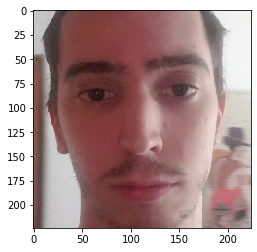

In [18]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"gian/gian_1.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

In [19]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 10.7 µs


Interrogo l'albero di ricerca

In [20]:
%%time
dist, ind = tree.query(simple_query_features.reshape(1, -1), k=10)

CPU times: user 8.67 ms, sys: 16.4 ms, total: 25.1 ms
Wall time: 6.55 ms


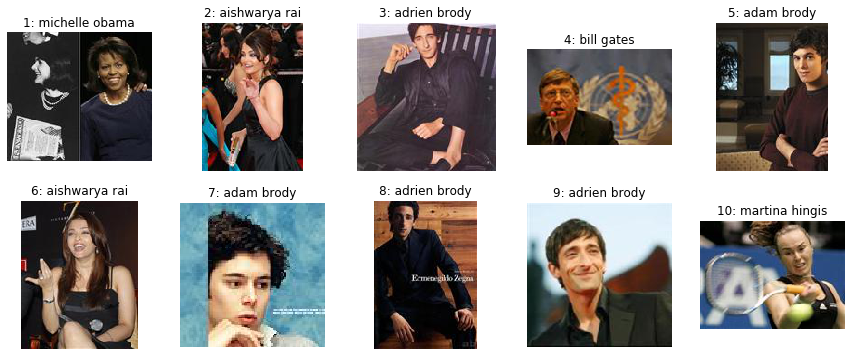

In [21]:
plot_imgs(paths, ind)

## Query #2

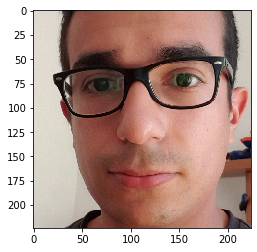

In [22]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"khaled/khaled_1.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

Interrogo l'albero di ricerca

In [23]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)
dist, ind = tree.query(simple_query_features.reshape(1, -1), k=10)

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 11.7 µs


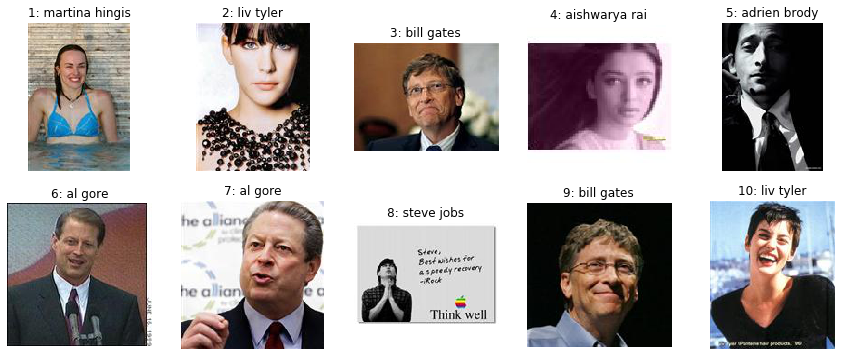

In [24]:
plot_imgs(paths, ind)

# Query all pictures for each person

We now query all pictures for:

- Alessandro,
- Alinda,
- Cami,
- Gian,
- Khaled,
- Luca,
- Mamma,
- Papi,

take the mode of the first ten retrieved celebrities, and count how many times each celebrity is considered the most similar.

In [25]:
from scipy.stats import mode

In [26]:
def query_all_pictures(cls, test_dir = "../Images/test_pictures/"):
    query_pictures = [test_dir+cls+"/"+f for f in os.listdir(test_dir+cls)]
    d = {}
    for cel in classes:
        d[cel] = 0
    maxl = np.max([len(cel) for cel in classes ]) + 1
        
    tot = len(query_pictures)
    i = 0
    for file in query_pictures:
        i+=1
        img =  kimage.load_img(file, target_size=(224, 224))
        simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)
        dist, ind = tree.query(simple_query_features.reshape(1, -1), k=10)
        predicted = np.array(paths)[ind[0]]
        predicted = [p.split("/")[-2] for p in predicted]
        predicted = mode(predicted)[0][0]
        d[predicted] += 1
        ipd.clear_output(wait=True)
        
        print(cls)
        print("Query #{}/{}\n".format(i, tot))
        
        print(f"{'':{maxl}s}  {'counts':},  {'Percent'}")
        for j in d.keys():
            # print("{:14s}: {:3d}, {:>02.2f}%".format(j, d[j], d[j]/i*100))
            print(f"{j:{maxl}s}: {d[j]:6d}, {d[j]/i*100:>7.2f}%")

In [27]:
%%time
query_all_pictures("alessandro")

alessandro
Query #394/394

                 counts,  Percent
michelle obama :      0,    0.00%
martina hingis :      2,    0.51%
liv tyler      :      4,    1.02%
bill gates     :     18,    4.57%
aishwarya rai  :      1,    0.25%
adrien brody   :     14,    3.55%
adam brody     :    250,   63.45%
steve jobs     :     79,   20.05%
aaron carter   :     21,    5.33%
al gore        :      5,    1.27%
CPU times: user 1min 40s, sys: 3min 12s, total: 4min 52s
Wall time: 1min 16s


In [28]:
%%time
query_all_pictures("alinda")

alinda
Query #138/138

                 counts,  Percent
michelle obama :      3,    2.17%
martina hingis :      5,    3.62%
liv tyler      :     25,   18.12%
bill gates     :     16,   11.59%
aishwarya rai  :     27,   19.57%
adrien brody   :      9,    6.52%
adam brody     :     28,   20.29%
steve jobs     :      5,    3.62%
aaron carter   :      8,    5.80%
al gore        :     12,    8.70%
CPU times: user 32.3 s, sys: 1min 1s, total: 1min 33s
Wall time: 25.1 s


In [29]:
%%time
query_all_pictures("cami")

cami
Query #220/220

                 counts,  Percent
michelle obama :      9,    4.09%
martina hingis :     11,    5.00%
liv tyler      :     59,   26.82%
bill gates     :     55,   25.00%
aishwarya rai  :     22,   10.00%
adrien brody   :     12,    5.45%
adam brody     :     23,   10.45%
steve jobs     :      0,    0.00%
aaron carter   :     12,    5.45%
al gore        :     17,    7.73%
CPU times: user 55 s, sys: 1min 45s, total: 2min 40s
Wall time: 42.4 s


In [30]:
%%time
query_all_pictures("gian")

gian
Query #234/234

                 counts,  Percent
michelle obama :      4,    1.71%
martina hingis :     32,   13.68%
liv tyler      :      1,    0.43%
bill gates     :     48,   20.51%
aishwarya rai  :     24,   10.26%
adrien brody   :     32,   13.68%
adam brody     :     42,   17.95%
steve jobs     :     28,   11.97%
aaron carter   :     11,    4.70%
al gore        :     12,    5.13%
CPU times: user 1min 8s, sys: 2min 5s, total: 3min 13s
Wall time: 55.6 s


In [31]:
%%time
query_all_pictures("khaled")

khaled
Query #308/308

                 counts,  Percent
michelle obama :      1,    0.32%
martina hingis :     12,    3.90%
liv tyler      :      3,    0.97%
bill gates     :     15,    4.87%
aishwarya rai  :     50,   16.23%
adrien brody   :      7,    2.27%
adam brody     :     18,    5.84%
steve jobs     :    141,   45.78%
aaron carter   :     45,   14.61%
al gore        :     16,    5.19%
CPU times: user 1min 30s, sys: 2min 43s, total: 4min 14s
Wall time: 1min 14s


In [32]:
%%time
query_all_pictures("luca")

luca
Query #550/550

                 counts,  Percent
michelle obama :      5,    0.91%
martina hingis :      5,    0.91%
liv tyler      :      8,    1.45%
bill gates     :    108,   19.64%
aishwarya rai  :    325,   59.09%
adrien brody   :     19,    3.45%
adam brody     :     39,    7.09%
steve jobs     :      8,    1.45%
aaron carter   :     12,    2.18%
al gore        :     21,    3.82%
CPU times: user 2min 26s, sys: 4min 39s, total: 7min 5s
Wall time: 1min 55s


In [33]:
%%time
query_all_pictures("mamma")

mamma
Query #711/711

                 counts,  Percent
michelle obama :      3,    0.42%
martina hingis :    456,   64.14%
liv tyler      :      7,    0.98%
bill gates     :     70,    9.85%
aishwarya rai  :      7,    0.98%
adrien brody   :     30,    4.22%
adam brody     :     87,   12.24%
steve jobs     :     26,    3.66%
aaron carter   :     16,    2.25%
al gore        :      9,    1.27%
CPU times: user 2min 51s, sys: 5min 29s, total: 8min 20s
Wall time: 2min 14s


In [34]:
%%time
query_all_pictures("papi")

papi
Query #362/362

                 counts,  Percent
michelle obama :     15,    4.14%
martina hingis :     26,    7.18%
liv tyler      :      3,    0.83%
bill gates     :     10,    2.76%
aishwarya rai  :      6,    1.66%
adrien brody   :    206,   56.91%
adam brody     :     11,    3.04%
steve jobs     :     10,    2.76%
aaron carter   :     31,    8.56%
al gore        :     44,   12.15%
CPU times: user 1min 34s, sys: 2min 59s, total: 4min 34s
Wall time: 1min 10s
